# Hackaton 

Welcome to this Hackaton! 

Today we are going to explore solar energy data to understand how solar energy is depending by several variables. We are going to build several prediction models to estimate the solar energy based on the variable forecast values. We will compare the prediction models to find the best model that fit our needs. Finally we are going to use this model to detect any potential anomaly detection in the solar energy measurement system. 

In [1]:
#import functional package for our project 
from sklearn import tree
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge,LinearRegression
import seaborn as sns
import tensorflow as tf
from tensorflow import keras as ks
%matplotlib inline
std_figsize = (16,10)

## 1. Data exploration

In [2]:
#import data from csv file 
data = pd.read_csv('https://raw.githubusercontent.com/peppusnight/just_for_data/main/DS.csv')
#filter only relevant data with energy not null 
data = data.loc[data.ISDAY.values>0.5,:]

# Feature selection
features = ['Radiation','HumRad','CloudRad','CLOUDCOVER','HUMIDITY','VISIBILITY',
            'TEMPERATURE','WINDSPEED','SOLARANGLE','HOUR']
# Target variable
target = 'Energy'

# Select data for training (df_X) and target variable (df_y)
data = data.loc[:, features + [target]]
df_X = data.loc[:, features]
df_y = data['Energy']
data

,Radiation,HumRad,CloudRad,CLOUDCOVER,HUMIDITY,VISIBILITY,TEMPERATURE,WINDSPEED,SOLARANGLE,HOUR,Energy
8,0.370893,14.093939,24.849840,33,62,10,8,14,0.203333,8,48.668503
9,0.641044,25.641750,41.026799,36,60,10,9,13,0.403333,9,145.144643
10,0.763060,32.048510,51.888063,32,58,10,9,14,0.603333,10,264.368857
11,0.812989,35.771497,57.722188,29,56,10,10,15,0.803333,11,270.687950
12,0.815704,36.706700,61.177833,25,55,10,10,15,0.996667,12,246.100395
...,...,...,...,...,...,...,...,...,...,...,...
300,0.833575,32.509413,30.008689,64,61,10,10,18,0.985334,12,210.910125
301,0.792706,28.537417,22.988475,71,64,10,10,17,0.819125,13,75.141045
302,0.689012,23.426394,14.469243,79,66,10,10,16,0.623585,14,46.327015
303,0.459581,14.706585,5.974550,87,68,10,10,15,0.428045,15,17.763858


In [3]:
#Data description 
data.describe()

,Radiation,HumRad,CloudRad,CLOUDCOVER,HUMIDITY,VISIBILITY,TEMPERATURE,WINDSPEED,SOLARANGLE,HOUR,Energy
count,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.00000,117.000000,117.000000,117.000000
mean,0.601792,24.841724,37.044738,38.538462,59.282051,9.854701,7.700855,19.34188,0.559496,12.000000,101.622815
std,0.244101,12.497810,25.318728,31.736126,10.428613,0.768619,2.009739,10.00014,0.260087,2.593094,83.051769
min,0.050187,0.978363,0.000000,1.000000,45.000000,5.000000,2.000000,4.00000,0.196667,8.000000,1.970556
25%,0.425301,16.279108,12.382815,9.000000,52.000000,10.000000,6.000000,12.00000,0.398443,10.000000,39.081250
50%,0.673551,23.426394,36.745606,32.000000,56.000000,10.000000,8.000000,17.00000,0.596667,12.000000,78.275090
75%,0.786533,35.365510,58.867070,61.000000,68.000000,10.000000,9.000000,28.00000,0.798084,14.000000,145.791223
max,0.833575,45.281714,81.224810,100.000000,81.000000,10.000000,11.000000,41.00000,1.000000,16.000000,292.353982


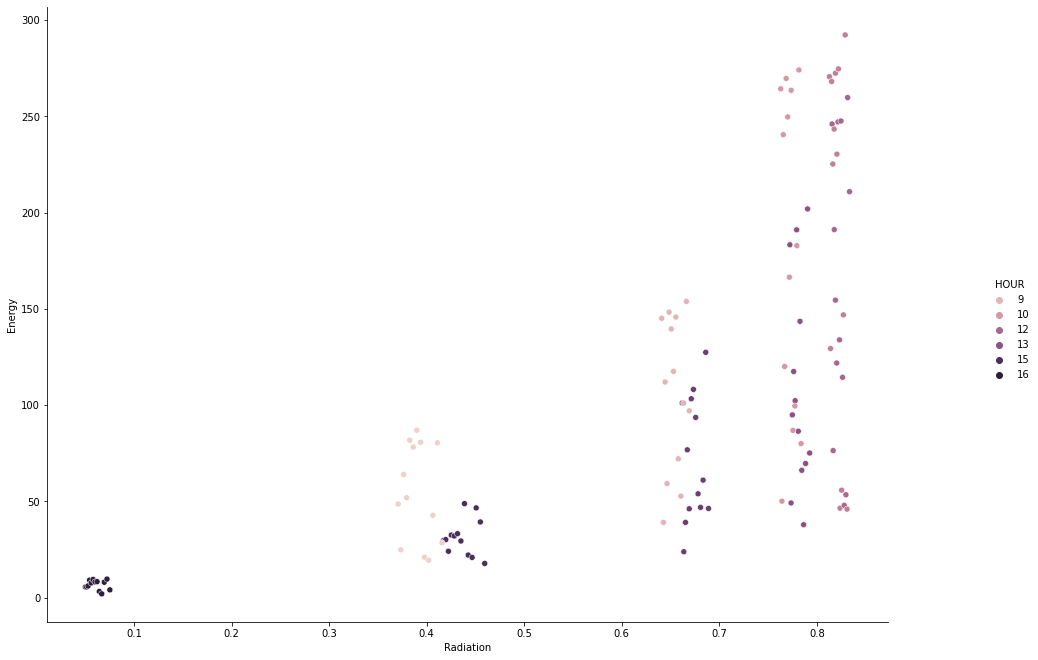

In [4]:
# how our target looks like? 
sns.relplot(data=data, y= 'Energy', x='Radiation', hue='HOUR')
fig = plt.gcf()
fig.set_size_inches(std_figsize)

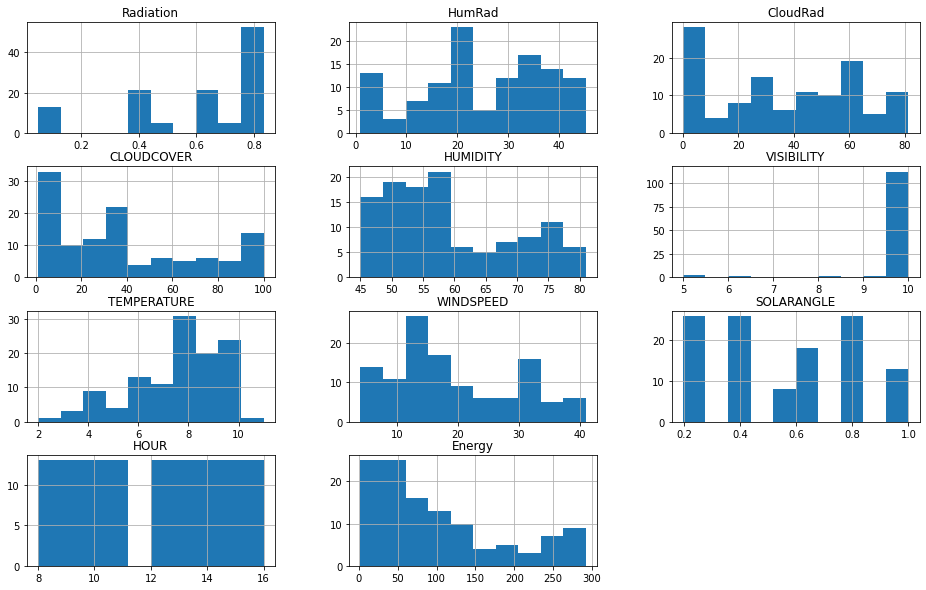

In [5]:
# get some insight on the data plotting some histogram, 
# check the unit of measure and value range and distribution of each variable 
_ = data.hist(figsize=std_figsize)

### 1.1 Correlation Analysis 

Evalaute the possible correlation between our target and the variables

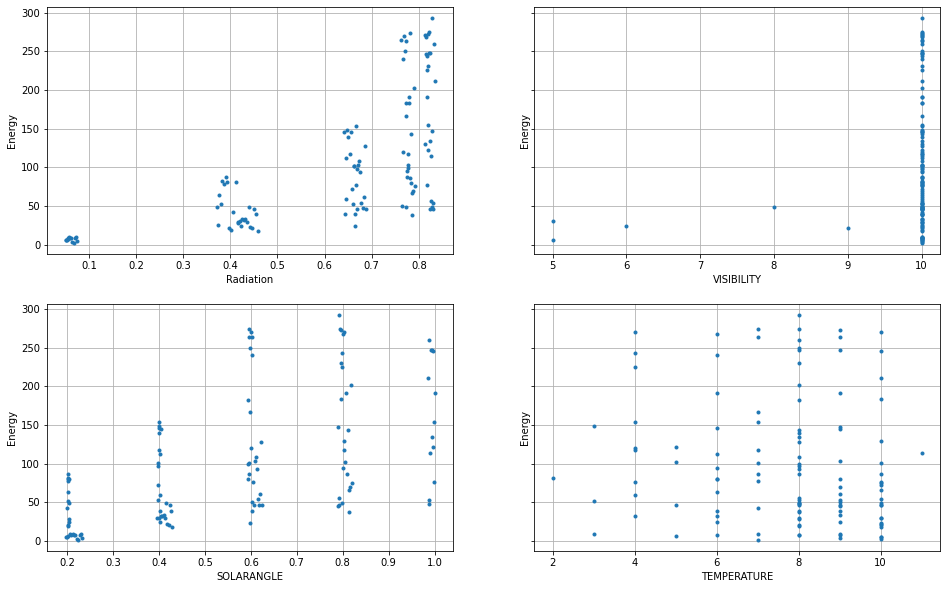

In [6]:
# some more closer look on Energy correlated variable 
f, ax = plt.subplots(2,2,sharey=True, figsize = std_figsize)
ax[0,0].plot(df_X['Radiation'], df_y, '.')
ax[0,0].set_xlabel('Radiation')
ax[0,1].plot(df_X['VISIBILITY'], df_y, '.')
ax[0,1].set_xlabel('VISIBILITY')
ax[1,1].plot(df_X['TEMPERATURE'], df_y, '.')
ax[1,1].set_xlabel('TEMPERATURE')
ax[1,0].plot(df_X['SOLARANGLE'], df_y, '.')
ax[1,0].set_xlabel('SOLARANGLE')
for a in ax.ravel(): a.grid(True); a.set_ylabel('Energy')

<AxesSubplot:>

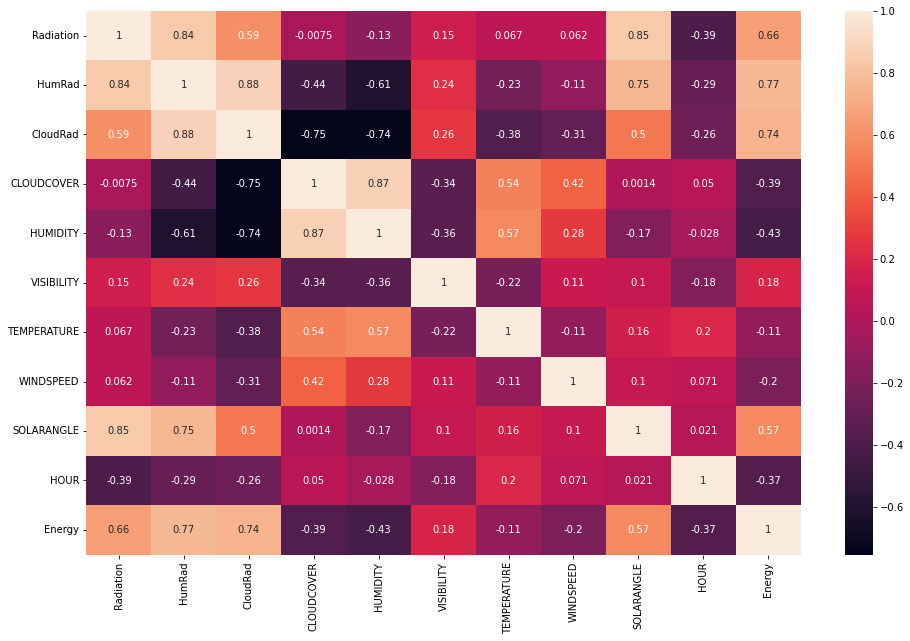

In [7]:
# let's get perception on correlation through heat map of the variables
plt.figure(figsize=std_figsize)
sns.heatmap(data.corr(), annot=True)

## 2. Data Preprocessing

Evaluate if the data need to be normalized. It might happen that due to the different nature of the data, the values could be very different between each other and this could influence the coefficient of the regression. 

In [6]:
# Training and test set split
features = ['Radiation','CloudRad','TEMPERATURE','WINDSPEED','HOUR']
X_train, X_test, y_train, y_test = train_test_split(df_X[features].values, df_y.values, test_size=0.3, random_state=2022)

# data normalization 
X_train_scaled = (X_train-np.mean(X_train,axis=0))/np.std(X_train,axis=0)
X_test_scaled  = (X_test-np.mean(X_train,axis=0))/np.std(X_train,axis=0)
y_train_scaled = (y_train-np.mean(y_train,axis=0))/np.std(y_train,axis=0)
y_test_scaled  = (y_test-np.mean(y_train,axis=0))/np.std(y_train,axis=0)
print('X_train number of points: ', len(X_train), 'which means ', len(X_train)/len(df_X[features])*100, '% of overall data')
print('X_test number of points: ', len(X_test), 'which means ', len(X_test)/len(df_X[features])*100, '% of overall data')

X_train number of points:  81 which means  69.23076923076923 % of overall data
X_test number of points:  36 which means  30.76923076923077 % of overall data


## 3. Models

in this section we are going to see what kind of different model we can elaborate to predict the solar energy as function of several variables. Check what are the feature of each models with its pros and cons. 

In [7]:
#define Root Mean Square Error to evalaute the performance of your model 
df = pd.DataFrame(data = {'rmse_train': [],
                                'mape_train': [],
                                'rmse_test': [],
                                'mape_test': []}, index = []).T

def mean_absolute_percentage_error(y_true,y_pred):
    abs_diff = np.abs(y_true-y_pred)/y_true
    mape = np.mean(abs_diff)
    return mape

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

def plot_results(y_train, y_test, X_train, X_test, model):
    f,ax = plt.subplots(2,2,sharex='col', figsize=std_figsize)
    ax[0,0].plot(y_train, '.-', label='Energy')
    ax[0,0].plot(model.predict(X_train), '.-', label='Predicted')
    ax[1,0].plot(y_train - model.predict(X_train).ravel(),'.-', label='Residuals')
    ax[0,1].plot(y_test, '.-', label='Energy')
    ax[0,1].plot(model.predict(X_test), '.-', label='Predicted')
    ax[1,1].plot(y_test - model.predict(X_test).ravel(),'.-', label='Residuals')
    ax[0,0].set_title('Training set')
    ax[0,1].set_title('Test set')
    for a in ax.ravel(): a.grid(True); a.legend(frameon=False);
    plt.figure(figsize=std_figsize)
    plt.scatter(y_test, model.predict(X_test).ravel())
    plt.plot(y_test,y_test)
    plt.xlabel('y_test')
    plt.ylabel('predicted')
    plt.grid()
    plt.show()
    rmse_train = rmse(y_train, model.predict(X_train))
    mape_train = 100*mean_absolute_percentage_error(y_train, model.predict(X_train).ravel())
    rmse_test  = rmse(y_test, model.predict(X_test))
    mape_test  = 100*mean_absolute_percentage_error(y_test, model.predict(X_test).ravel())
    print('RMSE on train set = {:.2f}'.format(rmse_train))
    print('MAPE on train set = {:.2f} '.format(mape_train))
    print('RMSE on test set = {:.2f}'.format(rmse_test))
    print('MAPE on test set = {:.2f} '.format(mape_test))
    
    return rmse_train, mape_train, rmse_test,mape_test

## Linear Regression Model

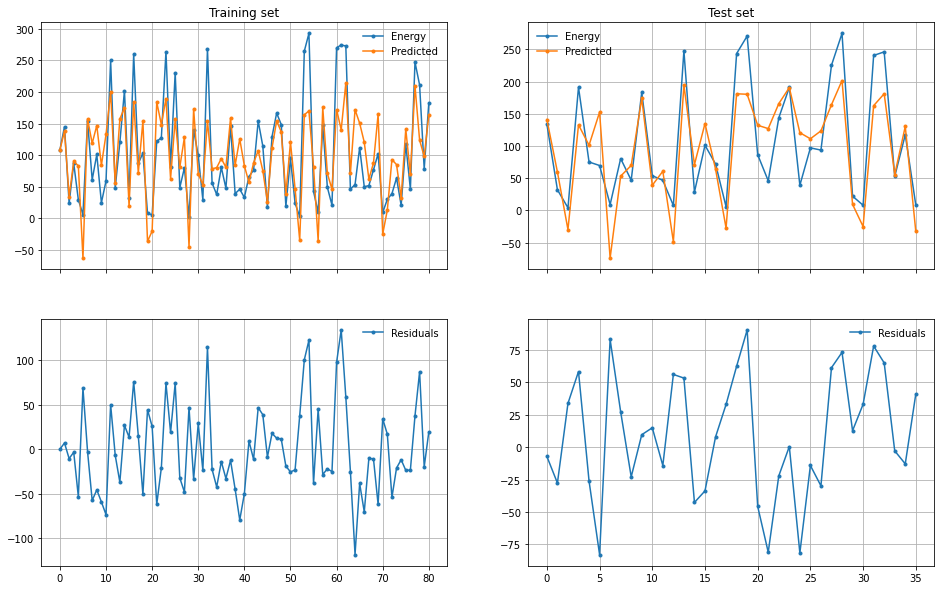

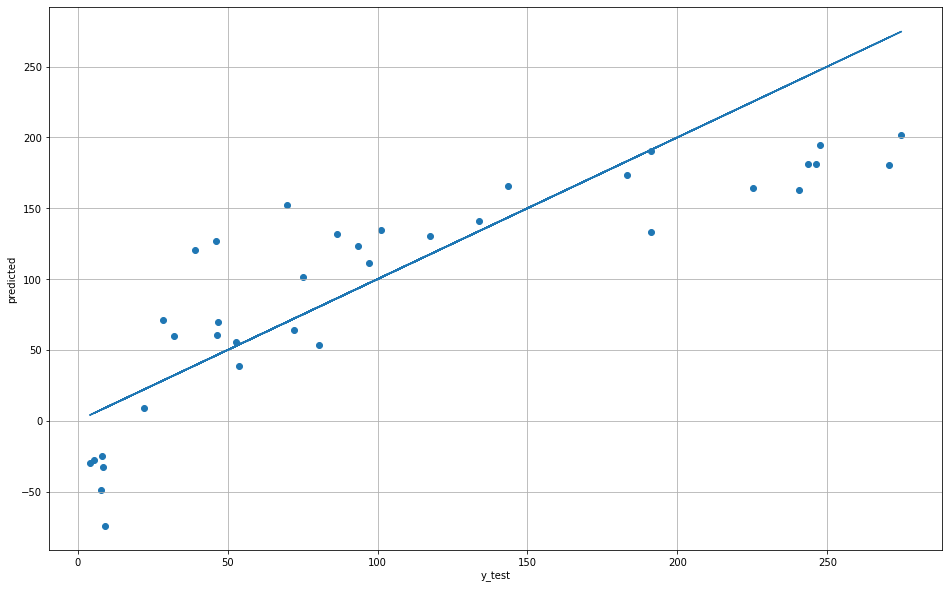

RMSE on train set = 49.63
MAPE on train set = 128.91 
RMSE on test set = 48.05
MAPE on test set = 148.80 


,RidgeLinear
rmse_train,49.631125
mape_train,128.912602
rmse_test,48.052215
mape_test,148.802376


In [8]:
##############################
# Modify only this parameter!!!!!
alpha  = 0 # Regularization parameter from 0 to Inf
solver = 'auto' # Solver:  lbfgs, svd, cholesky, lsqr, sparse_cg
tol = 0.0001 # Tolerance for convergence
##############################

# Fit the model
model_linear = Ridge(alpha = alpha, tol=tol, solver=solver)
model_linear.fit(X_train_scaled,y_train)
# print(model_linear.coef_)
# #evaluate linear model
# model_linear.predict(X_test_scaled)

df['RidgeLinear'] = plot_results(y_train, y_test, X_train_scaled, X_test_scaled, model_linear)
df

## Polynomial Regression Model

we can leverage on Explicif feature mapping to bring our ourginal features into an higher dimensional space. We can map linear features into a space with a polynomial basis, so by fitting a linear model in k feature we are really fitting a polynomial to the data.

Model Feature:  {'degree': 2, 'include_bias': True, 'interaction_only': False, 'order': 'C'}
Model Structure: ['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x2^2', 'x2 x3', 'x2 x4', 'x3^2', 'x3 x4', 'x4^2']


c:\Program Files\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


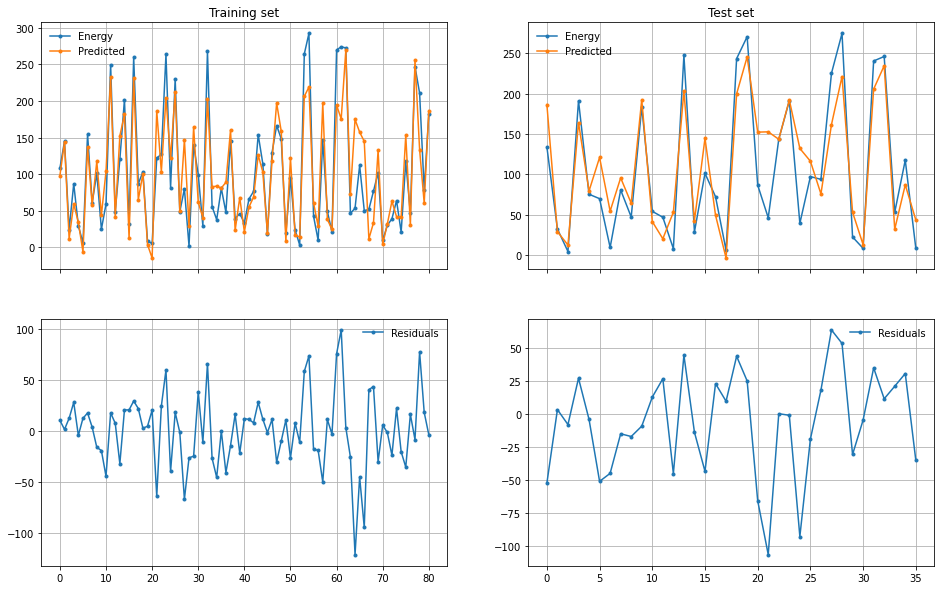

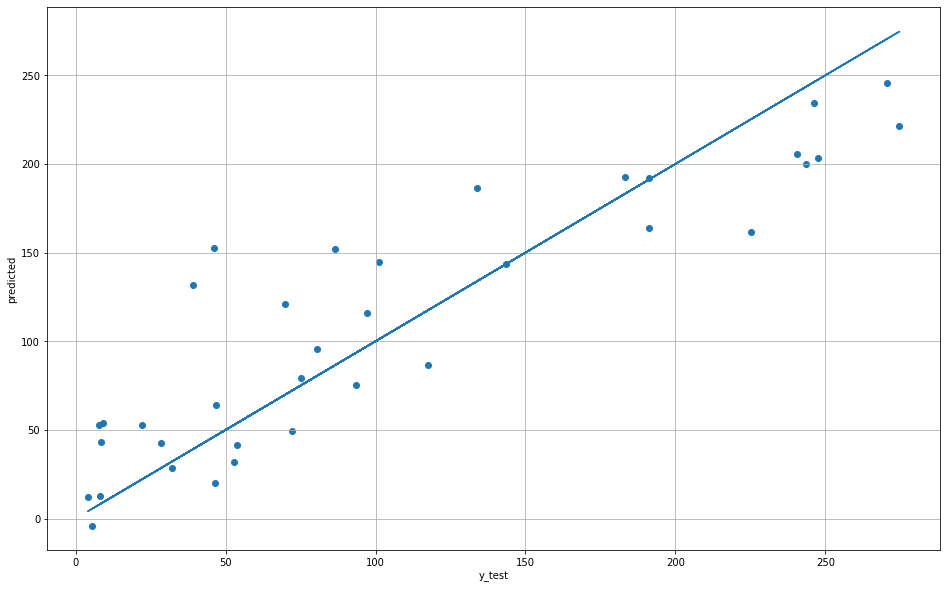

RMSE on train set = 36.29
MAPE on train set = 64.44 
RMSE on test set = 39.37
MAPE on test set = 90.14 


,RidgeLinear,RidgePoly
rmse_train,49.631125,36.294097
mape_train,128.912602,64.435014
rmse_test,48.052215,39.374406
mape_test,148.802376,90.135522


In [9]:
# Fit Polynomial Regression Model
######################
# Modify only this parameter!!!!!
polynomial_order = 2 # no more than 4!!!!
alpha  = 0 # Regularization parameter from 0 to Inf
solver = 'auto' # Solver: lbfgs, svd, cholesky, lsqr, sparse_cg
tol = 0.0001 # Tolerance for convergence
######################

model_polfeat = PolynomialFeatures(polynomial_order) # specify the degree of polynomial feature
model_polfeat.fit(X_train_scaled)

print("Model Feature: ",model_polfeat.get_params())
print("Model Structure:", model_polfeat.get_feature_names())

X_train_poly = model_polfeat.fit_transform(X_train_scaled)
X_test_poly = model_polfeat.fit_transform(X_test_scaled)

#fit the model on training dataset 
model_lin_polfeat = Ridge(alpha = alpha, tol=tol, solver=solver)
model_lin_polfeat.fit(X_train_poly,y_train)

#evaluate PolynomialFeatures model on test dataset
model_lin_polfeat.predict(X_test_poly)

df['RidgePoly'] = plot_results(y_train, y_test, X_train_poly, X_test_poly, model_lin_polfeat)
df

## Decision Tree

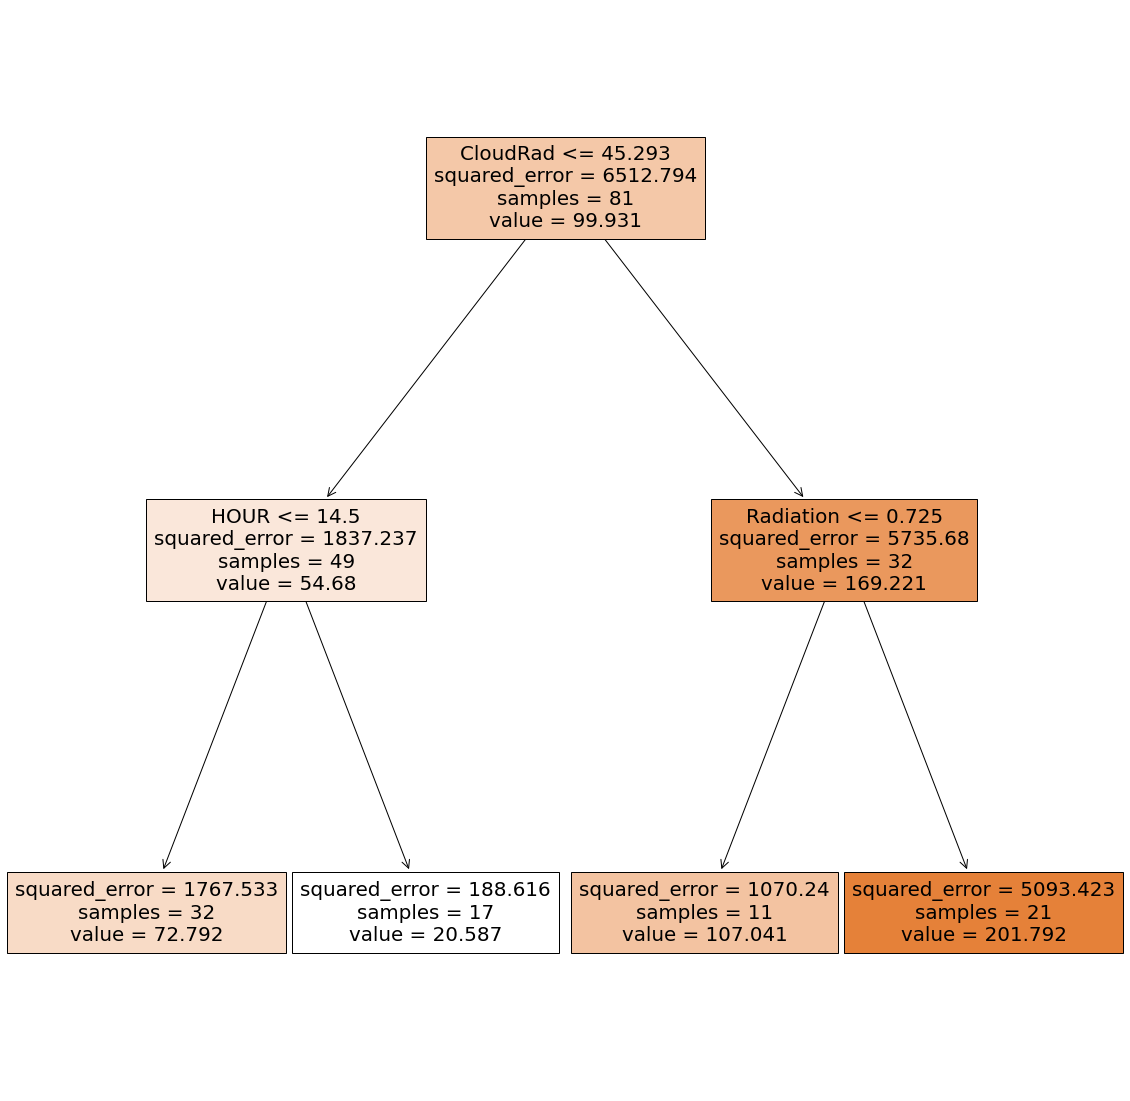

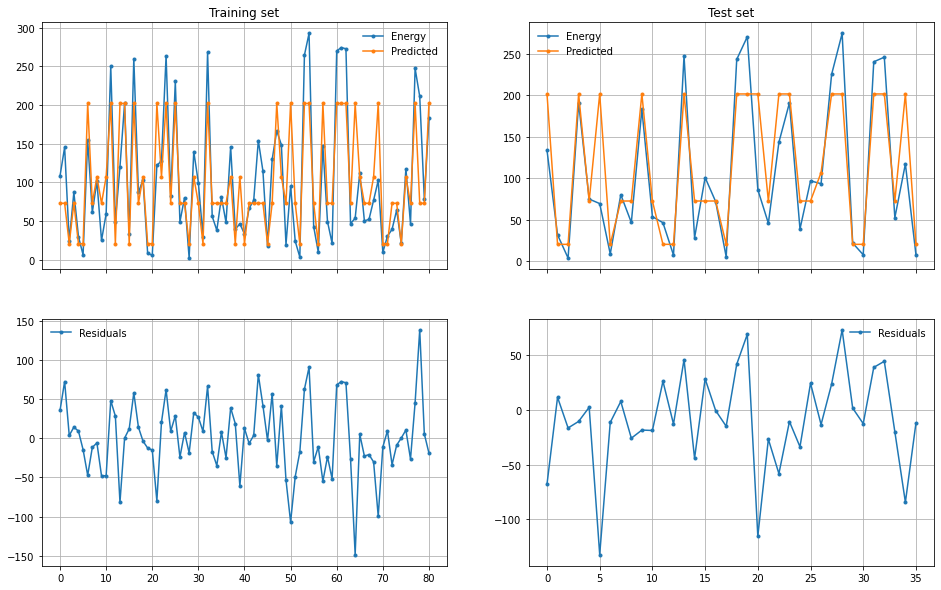

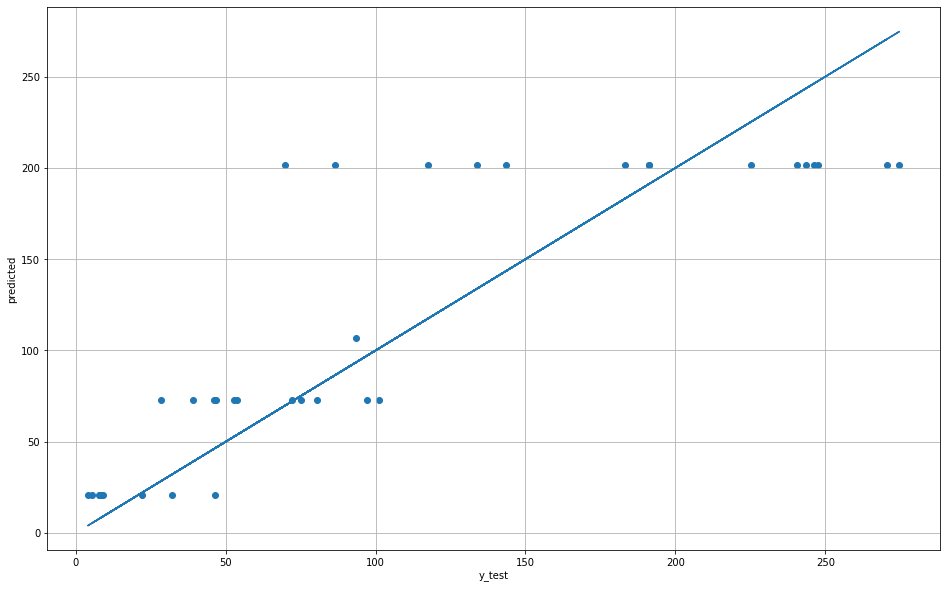

RMSE on train set = 46.94
MAPE on train set = 74.00 
RMSE on test set = 45.07
MAPE on test set = 70.08 


,RidgeLinear,RidgePoly,DecisionTree
rmse_train,49.631125,36.294097,46.943895
mape_train,128.912602,64.435014,74.003500
rmse_test,48.052215,39.374406,45.073822
mape_test,148.802376,90.135522,70.083261


In [10]:
################################
# Modify only these parameters!!!!
max_depth = 2
min_samples_leaf = 1
ccp_alpha = 0.0
################################

model_DT = DecisionTreeRegressor(random_state=2022, 
                                 max_depth=max_depth, 
                                 min_samples_leaf = min_samples_leaf,
                                 ccp_alpha=ccp_alpha)
model_DT.fit(X_train, y_train)

fig = plt.figure(figsize=(20,20))
_ = tree.plot_tree(model_DT,
                   feature_names=features,
                   class_names=True,
                   filled=True)

df['DecisionTree'] =plot_results(y_train, y_test, X_train, X_test, model_DT)
df

## Neural Network

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_Layer_1 (Dense)       (None, 10)                60        
_________________________________________________________________
Hidden_Layer_2 (Dense)       (None, 10)                110       
_________________________________________________________________
Hidden_Layer_3 (Dense)       (None, 10)                110       
_________________________________________________________________
Output_Layer (Dense)         (None, 1)                 11        
_________________________________________________________________
lambda_35 (Lambda)           (None, 1)                 0         
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________


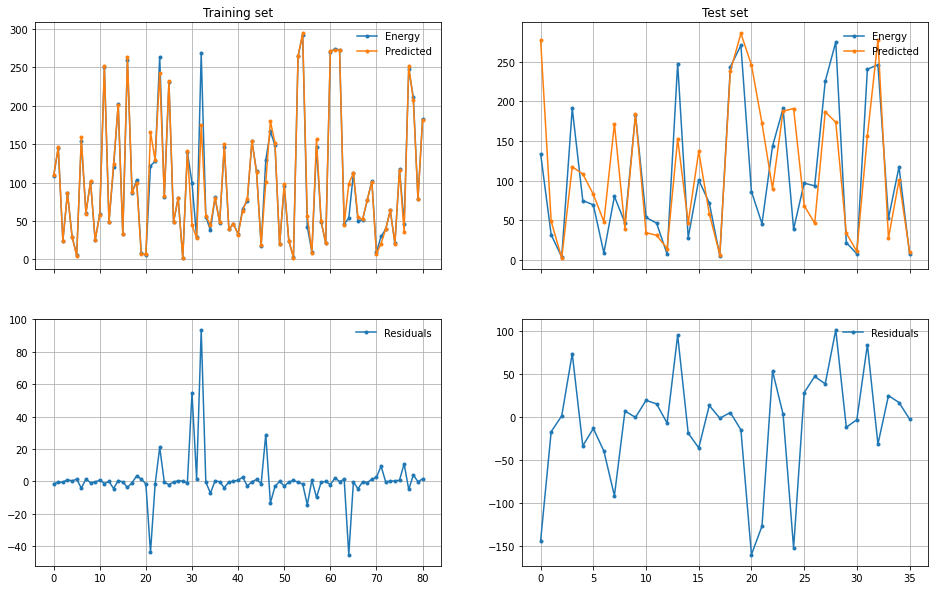

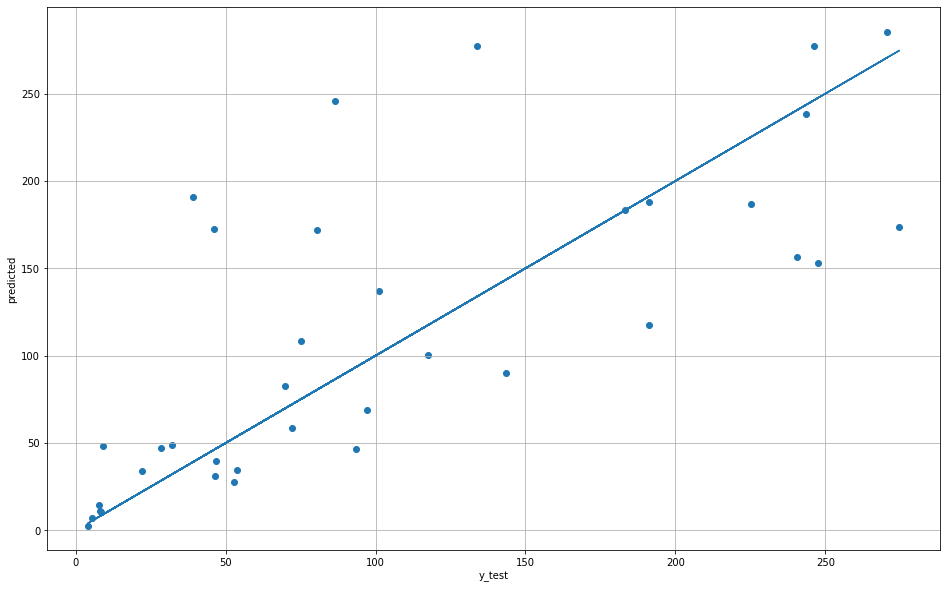

RMSE on train set = 14.86
MAPE on train set = 7.27 
RMSE on test set = 62.42
MAPE on test set = 68.20 


,RidgeLinear,RidgePoly,DecisionTree,NeuralNet
rmse_train,49.631125,36.294097,46.943895,14.863667
mape_train,128.912602,64.435014,74.003500,7.273327
rmse_test,48.052215,39.374406,45.073822,62.422955
mape_test,148.802376,90.135522,70.083261,68.196735


In [73]:
# NN model creation
#####################
# Modify only these parameters!!!
hidden_activation_function = 'relu' #options: relu softsign tanh sigmoid swish
hidden_layer_1 = 10
hidden_layer_2 = 10
hidden_layer_3 = 10
epoch = 500
#####################

# Fix the seed for reproducible results
np.random.seed(2022)
tf.random.set_seed(2022)

input_data_shape = (len(features),)
dnn_model = ks.models.Sequential()
dnn_model.add(ks.layers.Input(shape=input_data_shape, name = 'Input_Layer'))
dnn_model.add(ks.layers.Dense(hidden_layer_1, activation=hidden_activation_function, name = 'Hidden_Layer_1'))
dnn_model.add(ks.layers.Dense(hidden_layer_2, activation=hidden_activation_function, name = 'Hidden_Layer_2'))
dnn_model.add(ks.layers.Dense(hidden_layer_3, activation=hidden_activation_function, name = 'Hidden_Layer_3'))
dnn_model.add(ks.layers.Dense(1, name = 'Output_Layer'))
dnn_model.add(ks.layers.Lambda(lambda x: 1.5*max(y_train)*x))
dnn_model.summary()

# NN Model Trainig
optimizer = 'adam'
loss_function = 'mean_absolute_error'
metric =['accuracy']
dnn_model.compile(optimizer = optimizer, loss= loss_function, metrics=metric)
history = dnn_model.fit(X_train_scaled, y_train, epochs = epoch, verbose=0)

df['NeuralNet'] = plot_results(y_train, y_test, X_train_scaled, X_test_scaled, dnn_model)
df

## Model Comparison

In [74]:
df

,RidgeLinear,RidgePoly,DecisionTree,NeuralNet
rmse_train,49.631125,36.294097,46.943895,14.863667
mape_train,128.912602,64.435014,74.003500,7.273327
rmse_test,48.052215,39.374406,45.073822,62.422955
mape_test,148.802376,90.135522,70.083261,68.196735


## Anomaly Detection Model 

Based on your best model selected, detect a possible anomaly on a new dataset. What your model says? what your data are saying? 

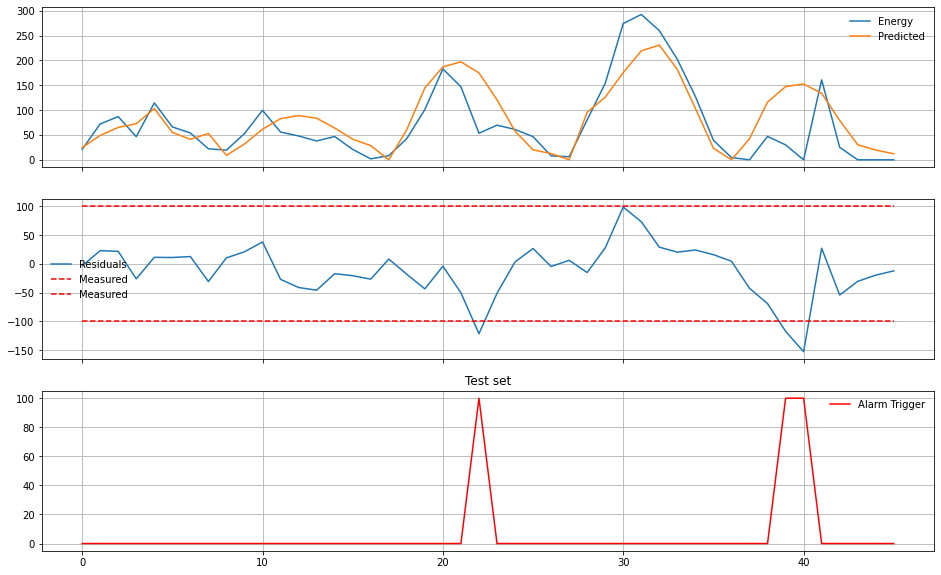

In [15]:
##############################
# Use only the following codes!!! # NN, DecisionTree, Linear, PolyLinear
model_selected = 'PolyLinear'
##############################

#import data from csv file 
data_AnomalDetect = pd.read_csv('https://raw.githubusercontent.com/peppusnight/just_for_data/main/DS_Anomaly_Version.csv')

#selection of input values and measured value in field 
features = ['Radiation','CloudRad','TEMPERATURE','WINDSPEED','HOUR']

X_model = data_AnomalDetect.loc[:, features]
Y_meas = data_AnomalDetect['Energy']

# data normalization to feed the model (normaliation according to training set on which model has been developed)
X_model_scaled = (X_model-np.mean(X_train,axis=0))/np.std(X_train,axis=0)
X_model_scaled_poly = model_polfeat.fit_transform(X_model_scaled)

if model_selected=='NN':
    Y_model = dnn_model.predict(X_model_scaled).ravel()
elif model_selected=='DecisionTree':
    Y_model = model_DT.predict(X_model)
elif model_selected=='Linear':
    Y_model = model_linear.predict(X_model_scaled)
elif model_selected=='PolyLinear':
    Y_model = model_lin_polfeat.predict(X_model_scaled_poly)

Y_model[Y_model<0] = 0
# Alm Threshold
AlmThreshold = 100
AlmThreshold = np.ones(len(data_AnomalDetect), dtype=float) * AlmThreshold

alm = pd.DataFrame()

#check for every point if they are in alarm
for i in range(len(data_AnomalDetect)):
    if abs(Y_meas[i]-Y_model[i])<100:
        alm.loc[i,'Allarm']=0
    else:
        alm.loc[i,'Allarm']=100
f,ax = plt.subplots(3,sharex='col', figsize=std_figsize)
ax[0].plot(data_AnomalDetect.index, Y_meas , label='Energy')
ax[0].plot(data_AnomalDetect.index, Y_model, label='Predicted')

ax[1].plot(data_AnomalDetect.index,Y_meas - Y_model, label='Residuals')
ax[1].plot(data_AnomalDetect.index, AlmThreshold, '--', label='Measured', color='r')
ax[1].plot(data_AnomalDetect.index, -AlmThreshold, '--', label='Measured', color='r')

ax[2].plot(data_AnomalDetect.index, alm, label='Alarm Trigger', color='r',)
ax[2].set_title('Training set')
ax[2].set_title('Test set')
for a in ax.ravel(): a.grid(True); a.legend(frameon=False);

Where the alarm has been trigged? 

check the solution and see what are the data that has been artificially altered.

## Conclusion
In this session we have seen how to interpretate your data, how to test different models and tune their parameters to get the most accurate model. Then we have seen how to use the model for application in anomaly detection. 